In [1]:
# import modin.pandas as pd
import pandas as pd
import datetime
import math
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# # data_set = 
# data_sets = {
#     'sp500': {
#         'data': pd.read_csv(f'/Users/gabeheim/documents/concatenated_price_data/sp500.csv', index_col=False).drop(['Adj Close'], axis=1)
#     },
#     'BTCUSDT': {
#         'data': pd.read_csv(f'/Users/gabeheim/documents/concatenated_price_data/BTCUSDT.csv', index_col=False)
#     }
# }

# data_sets['BTCUSDT']['data'] = data_sets['BTCUSDT']['data'][:math.floor(len(data_sets['BTCUSDT']['data'])/32)]#16)]

# # display(data_sets['sp500']['data'])
# data_sets['BTCUSDT']['data']

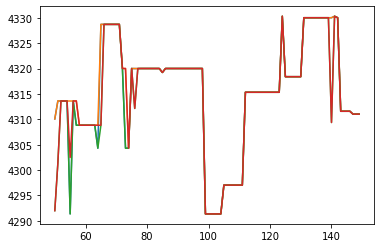

In [319]:
data = data_sets['BTCUSDT']['data']
end = 150
plt.plot(data.index[50:end], data.Close[50:end])
plt.plot(data.index[50:end], data.High[50:end])
plt.plot(data.index[50:end], data.Low[50:end])
plt.plot(data.index[50:end], data.Open[50:end])
plt.show()

In [320]:
# target_percent = 0.01
# display(data.High[0:0+train_window+1])
# print(1455.219971 * (1 + target_percent))
# data.High[0:0+train_window+1].loc[data.High >= 1455.219971 * (1 + target_percent)]#.index[0]
data_sets['BTCUSDT']['data'].Close.pct_change().mean() * 1000

0.007492893252647893

In [ ]:
from functools import partial
import multiprocessing
import time

def get_labels(row, target_percent=.01, stop_loss_percent=.005, mode='since3'):
    if mode == 'since':
        try:
            target_index = data.loc[row[6]:][data.Close >= row[4] * (1 + target_percent)].iloc[0]._name
        except IndexError:
            target_index = data.index.max() + 5
        try:
            stop_loss_index = data.loc[row[6]:][data.Close <= row[4] * (1 - stop_loss_percent)].iloc[0]._name
        except IndexError:
            stop_loss_index = data.index.max() + 5
        if target_index > stop_loss_index:
            return 0
        elif target_index < stop_loss_index:
            return 1
        return None
    if mode == 'average':
        mean = data.Close[row[6]:row[6]+10].mean()
#         print(mean)
        if mean - row[4] > 0: #row[4] * (1 + target_percent):
            return 1
#         elif mean <= row[4] * (1 - stop_loss_percent):
#             return -1
        else:
            return 0
        return None
    if mode == 'next':
        print('nextnensnes')
        try:
            next = data.Close.values[row[6]+1]
        except:
            next = 0
#         print(next)
        if next > row[4]: #row[4] * (1 + target_percent):
            return 1
#         elif mean <= row[4] * (1 - stop_loss_percent):
#             return -1
        else:
            return 0
        return None
    if mode == 'since3':
#         max_index = data.High[row[6]:row[6]+21].idxmax()
#         min_index = data.Low[row[6]:row[6]+21].idxmin()
        try:
#             target_index = data.High[row[6]:row[6]+train_window+1].loc[data.High >= row[4] * (1 + target_percent)].index[0]
            target_index = data.Close[row[6]:row[6]+train_window+1].loc[data.Close >= row[4] * (1 + target_percent)].index[0]
        except IndexError:
            target_index = data.index.max() + 5
        try:
#             stop_loss_index = data.Low[row[6]:row[6]+train_window+1].loc[data.Low <= row[4] * (1 - stop_loss_percent)].index[0]
            stop_loss_index = data.Close[row[6]:row[6]+train_window+1].loc[data.Close <= row[4] * (1 - stop_loss_percent)].index[0]
        except IndexError:
            stop_loss_index = data.index.max() + 5
        if target_index > stop_loss_index:
            return 0
        elif target_index < stop_loss_index:
            return 2
        return 1

for name, datad in data_sets.items():
    data = datad['data']
    train_window = 20
    data['index'] = data.index
    # too volatile class?
    n = 0
    pool = multiprocessing.Pool(multiprocessing.cpu_count() - n)                         # Create a multiprocessing Pool

    start = time.time()
    data['label'] = pool.map(partial(get_labels, mode='next'), [tuple(r) for r in data.to_numpy()])  # process data_inputs iterable with pool
    print(name, 'pool label took: ', time.time() - start)

data_sets['BTCUSDT']['data']

In [339]:
for name, datad in data_sets.items():
    data = datad['data']
    for label in sorted(data.label.unique()):
        print(name, label, len(data.loc[data.label == label]))

BTCUSDT 0 9291
BTCUSDT 1 13204
BTCUSDT 2 3520


In [340]:
import talib as ta
for name, datad in data_sets.items():
    data = datad['data']
    data['sma_10'] = ta.SMA(data.Close, timeperiod=10)
    macd, macd_signal, macd_hist = ta.MACDFIX(data.Close, signalperiod=9)
    data['macd'] = macd
    data['macd_signal'] = macd_signal
    data['macd_hist'] = macd_hist
    data['cci_24'] = ta.CCI(data.High, data.Low, data.Close, timeperiod=24)
    data['mom_10'] = ta.MOM(data.Close, timeperiod=10)
    data['roc_10'] = ta.ROC(data.Close, timeperiod=10)
    data['rsi_5'] = ta.RSI(data.Close, timeperiod=5)
    data['wnr_9'] = ta.WILLR(data.High, data.Low, data.Close, timeperiod=9)
    slowk, slowd = ta.STOCH(data.High, data.Low, data.Close, fastk_period=5, 
                            slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    data['slowk'] = slowk
    data['slowd'] = slowd
    data['adosc'] = ta.ADOSC(data.High, data.Low, data.Close, data.Volume, fastperiod=3, slowperiod=10)
    data = data[10:].reset_index()
    data = data.drop(['level_0'], axis=1)
    data['index'] = data.index

data_sets['BTCUSDT']['data']

,Date,Open,High,Low,Close,Volume,index,label,sma_10,macd,...,macd_signal_percentage,macd_hist_percentage,cci_24_percentage,mom_10_percentage,roc_10_percentage,rsi_5_percentage,wnr_9_percentage,slowk_percentage,slowd_percentage,adosc_percentage
0,2017-08-17 04:00:00.000000,4261.48,4261.48,4261.48,4261.48,1.775183,0,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
1,2017-08-17 04:01:00.000000,4261.48,4261.48,4261.48,4261.48,0.000000,1,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
2,2017-08-17 04:02:00.000000,4280.56,4280.56,4280.56,4280.56,0.261074,2,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
3,2017-08-17 04:03:00.000000,4261.48,4261.48,4261.48,4261.48,0.012008,3,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
4,2017-08-17 04:04:00.000000,4261.48,4261.48,4261.48,4261.48,0.140796,4,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26010,2017-09-04 05:30:00.000000,4462.50,4462.50,4462.50,4462.50,0.000000,26010,0,4448.883,7.942480,...,0.001675,-0.006731,0.000452,-0.006640,-0.006597,-1.0,-0.997032,0.000144,-0.001621,0.002114
26011,2017-09-04 05:31:00.000000,4466.97,4466.97,4466.97,4466.97,0.198468,26011,0,4448.980,8.922450,...,0.002119,-0.017800,0.002359,-0.007460,-0.007413,-1.0,-1.000000,0.000144,-0.001621,0.002114
26012,2017-09-04 05:32:00.000000,4466.97,4466.97,4466.97,4466.97,0.000000,26012,0,4449.077,9.592574,...,0.002336,0.002387,0.000632,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
26013,2017-09-04 05:33:00.000000,4433.95,4433.95,4433.94,4433.94,0.784977,26013,0,4446.500,7.534293,...,0.001399,-0.013418,-0.013633,-0.045152,-0.044959,-1.0,-0.997032,0.000144,-0.001621,0.002114


In [341]:


independent_indicators = ['macd', 'macd_signal', 'macd_hist', 'cci_24', 'mom_10', 'roc_10','rsi_5','wnr_9','slowk','slowd','adosc'] 
for name, datad in data_sets.items():
    data = datad['data']
    for indicator in independent_indicators:
        name = indicator + '_min_max'
        mean = data[indicator].mean()
        std = data[indicator].std()
        data[indicator].loc[data[indicator] > mean + 3 * std] = mean + 3 * std
        data[indicator].loc[data[indicator] < mean - 3 * std] = mean - 3 * std
        data[name] = (data[indicator] - mean) / std 
        data[name] = minmax_scale(data[indicator], feature_range=(-1,1))
data_sets['BTCUSDT']['data']

,Date,Open,High,Low,Close,Volume,index,label,sma_10,macd,...,macd_signal_percentage,macd_hist_percentage,cci_24_percentage,mom_10_percentage,roc_10_percentage,rsi_5_percentage,wnr_9_percentage,slowk_percentage,slowd_percentage,adosc_percentage
0,2017-08-17 04:00:00.000000,4261.48,4261.48,4261.48,4261.48,1.775183,0,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
1,2017-08-17 04:01:00.000000,4261.48,4261.48,4261.48,4261.48,0.000000,1,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
2,2017-08-17 04:02:00.000000,4280.56,4280.56,4280.56,4280.56,0.261074,2,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
3,2017-08-17 04:03:00.000000,4261.48,4261.48,4261.48,4261.48,0.012008,3,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
4,2017-08-17 04:04:00.000000,4261.48,4261.48,4261.48,4261.48,0.140796,4,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26010,2017-09-04 05:30:00.000000,4462.50,4462.50,4462.50,4462.50,0.000000,26010,0,4448.883,7.942480,...,0.001675,-0.006731,0.000452,-0.006640,-0.006597,-1.0,-0.997032,0.000144,-0.001621,0.002114
26011,2017-09-04 05:31:00.000000,4466.97,4466.97,4466.97,4466.97,0.198468,26011,0,4448.980,8.922450,...,0.002119,-0.017800,0.002359,-0.007460,-0.007413,-1.0,-1.000000,0.000144,-0.001621,0.002114
26012,2017-09-04 05:32:00.000000,4466.97,4466.97,4466.97,4466.97,0.000000,26012,0,4449.077,9.592574,...,0.002336,0.002387,0.000632,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
26013,2017-09-04 05:33:00.000000,4433.95,4433.95,4433.94,4433.94,0.784977,26013,0,4446.500,7.534293,...,0.001399,-0.013418,-0.013633,-0.045152,-0.044959,-1.0,-0.997032,0.000144,-0.001621,0.002114


In [342]:
percentage_indicators = ['Close', 'Volume', 'sma_10'] + independent_indicators
for name, datad in data_sets.items():
    data = datad['data']
    for indicator in percentage_indicators:
        name = indicator + '_percentage'
        data[name] = data[indicator].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
        mean = data[name].mean()
        std = data[name].std()
        data[name].loc[data[name] > mean + 3 * std] = mean + 3 * std
        data[name].loc[data[name] < mean - 3 * std] = mean - 3 * std
        data[name] = (data[name] - mean) / std 
        data[name] = minmax_scale(data[name], feature_range=(-1, 1))
data_sets['BTCUSDT']['data']

,Date,Open,High,Low,Close,Volume,index,label,sma_10,macd,...,macd_signal_percentage,macd_hist_percentage,cci_24_percentage,mom_10_percentage,roc_10_percentage,rsi_5_percentage,wnr_9_percentage,slowk_percentage,slowd_percentage,adosc_percentage
0,2017-08-17 04:00:00.000000,4261.48,4261.48,4261.48,4261.48,1.775183,0,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
1,2017-08-17 04:01:00.000000,4261.48,4261.48,4261.48,4261.48,0.000000,1,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
2,2017-08-17 04:02:00.000000,4280.56,4280.56,4280.56,4280.56,0.261074,2,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
3,2017-08-17 04:03:00.000000,4261.48,4261.48,4261.48,4261.48,0.012008,3,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
4,2017-08-17 04:04:00.000000,4261.48,4261.48,4261.48,4261.48,0.140796,4,1,NaN,NaN,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26010,2017-09-04 05:30:00.000000,4462.50,4462.50,4462.50,4462.50,0.000000,26010,0,4448.883,7.942480,...,0.001675,-0.006731,0.000452,-0.006640,-0.006597,-1.0,-0.997032,0.000144,-0.001621,0.002114
26011,2017-09-04 05:31:00.000000,4466.97,4466.97,4466.97,4466.97,0.198468,26011,0,4448.980,8.922450,...,0.002119,-0.017800,0.002359,-0.007460,-0.007413,-1.0,-1.000000,0.000144,-0.001621,0.002114
26012,2017-09-04 05:32:00.000000,4466.97,4466.97,4466.97,4466.97,0.000000,26012,0,4449.077,9.592574,...,0.002336,0.002387,0.000632,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
26013,2017-09-04 05:33:00.000000,4433.95,4433.95,4433.94,4433.94,0.784977,26013,0,4446.500,7.534293,...,0.001399,-0.013418,-0.013633,-0.045152,-0.044959,-1.0,-0.997032,0.000144,-0.001621,0.002114


In [343]:


INVALID_LABEL = 99

dependent_indicators = ['Open','High','Low','Close','Volume', 'sma_10']

for name, datad in data_sets.items():
    data = datad['data']
    datad['features'] = data.copy().drop(['index', 'Date', 'label'] + dependent_indicators + independent_indicators, axis=1
                               ).fillna(0).replace([np.inf, -np.inf], np.nan).ffill()

    display(datad['features'])

    datad['labels'] = data['label'].copy().replace([np.inf, -np.inf], np.nan).fillna(INVALID_LABEL)

    display(datad['labels'])

,macd_min_max,macd_signal_min_max,macd_hist_min_max,cci_24_min_max,mom_10_min_max,roc_10_min_max,rsi_5_min_max,wnr_9_min_max,slowk_min_max,slowd_min_max,...,macd_signal_percentage,macd_hist_percentage,cci_24_percentage,mom_10_percentage,roc_10_percentage,rsi_5_percentage,wnr_9_percentage,slowk_percentage,slowd_percentage,adosc_percentage
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001840,-0.002316,0.001399,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26010,0.375231,0.425596,-0.042448,0.218187,0.028397,0.025506,0.245191,0.874826,1.000000,0.333333,...,0.001675,-0.006731,0.000452,-0.006640,-0.006597,-1.0,-0.997032,0.000144,-0.001621,0.002114
26011,0.421786,0.432460,0.070574,0.236779,0.011126,0.009311,0.297502,1.000000,1.000000,0.777778,...,0.002119,-0.017800,0.002359,-0.007460,-0.007413,-1.0,-1.000000,0.000144,-0.001621,0.002114
26012,0.453621,0.444894,0.127932,0.220684,0.011126,0.009311,0.297502,1.000000,1.000000,1.000000,...,0.002336,0.002387,0.000632,-0.006634,-0.006591,-1.0,-0.997032,0.000144,-0.001621,0.002114
26013,0.355839,0.433519,-0.117287,-0.073693,-0.318760,-0.299752,-0.279231,0.080840,0.333333,0.777778,...,0.001399,-0.013418,-0.013633,-0.045152,-0.044959,-1.0,-0.997032,0.000144,-0.001621,0.002114


0        1
1        1
2        1
3        1
4        1
        ..
26010    0
26011    0
26012    0
26013    0
26014    1
Name: label, Length: 26015, dtype: int64

In [344]:
from sklearn.decomposition import PCA
pca_components = 10
def get_pca_features(features, pca_components=10):

    pca = PCA(n_components=pca_components)
    features_pca = pd.DataFrame(pca.fit_transform(features))
    return features_pca

def rfe(features, labels, sample_size=2000, trials=4, select=10):
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=1)#, step=1)
    sums = [0] * len(features.columns)
    for trial in range(trials):
        samples = features.sample(n=sample_size)
        selector = selector.fit(samples, labels.loc[samples.index])
        print(selector.ranking_)
        sums = [sum(i) for i in zip(sums, selector.ranking_)]
        print(sums)
        print()
    
    return features[[features.columns[i] for i in np.argsort(sums)[-select:] ]]

for name, datad in data_sets.items():
    features = datad['features']
    labels = datad['labels']
    print(name)
    datad['rfe_features'] = rfe(features, labels, sample_size=2000, trials=4, select=10)
    display(datad['rfe_features'])

BTCUSDT
[14 11  1 12  6  5 22 23  9 10 15  2  3  7 20  8 16 21 13 18 24 19 17  4
 25]
[14, 11, 1, 12, 6, 5, 22, 23, 9, 10, 15, 2, 3, 7, 20, 8, 16, 21, 13, 18, 24, 19, 17, 4, 25]

[ 1  2 23  5 10  9 22 25  7  8 13  3  4 11 16  6 17 24 18 15 20 14 21 12
 19]
[15, 13, 24, 17, 16, 14, 44, 48, 16, 18, 28, 5, 7, 18, 36, 14, 33, 45, 31, 33, 44, 33, 38, 16, 44]

[ 4  5  7 15  2  1 20 19  9 11 23  6 13  3 16 10 12 14 18 21 24 17 22  8
 25]
[19, 18, 31, 32, 18, 15, 64, 67, 25, 29, 51, 11, 20, 21, 52, 24, 45, 59, 49, 54, 68, 50, 60, 24, 69]

[ 5  6 22 10  3 17 19 18 12 13 21  1 24 20  2 15  4  7 23 16 11 14  9  8
 25]
[24, 24, 53, 42, 21, 32, 83, 85, 37, 42, 72, 12, 44, 41, 54, 39, 49, 66, 72, 70, 79, 64, 69, 32, 94]



,wnr_9_percentage,cci_24_percentage,slowk_percentage,roc_10_percentage,mom_10_percentage,adosc_min_max,rsi_5_percentage,rsi_5_min_max,wnr_9_min_max,adosc_percentage
0,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
1,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
2,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
3,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
4,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
...,...,...,...,...,...,...,...,...,...,...
26010,-0.997032,0.000452,0.000144,-0.006597,-0.006640,0.411670,-1.0,0.245191,0.874826,0.002114
26011,-1.000000,0.002359,0.000144,-0.007413,-0.007460,0.336225,-1.0,0.297502,1.000000,0.002114
26012,-0.997032,0.000632,0.000144,-0.006591,-0.006634,0.274284,-1.0,0.297502,1.000000,0.002114
26013,-0.997032,-0.013633,0.000144,-0.044959,-0.045152,0.134002,-1.0,-0.279231,0.080840,0.002114


In [345]:
for name, datad in data_sets.items():
    rfe_features = datad['rfe_features']
    datad['rfe_pca_features'] = get_pca_features(rfe_features, pca_components=7)
    display(datad['rfe_pca_features'])

,0,1,2,3,4,5,6
0,0.022396,0.010892,0.010192,-0.016525,-0.002421,-0.002023,0.002334
1,0.022396,0.010892,0.010192,-0.016525,-0.002421,-0.002023,0.002334
2,0.022396,0.010892,0.010192,-0.016525,-0.002421,-0.002023,0.002334
3,0.022396,0.010892,0.010192,-0.016525,-0.002421,-0.002023,0.002334
4,0.022396,0.010892,0.010192,-0.016525,-0.002421,-0.002023,0.002334
...,...,...,...,...,...,...,...
26010,-0.911024,-0.248434,0.247482,-0.008016,-0.000371,-0.004168,0.001292
26011,-1.038927,-0.214203,0.166401,-0.007982,0.000853,-0.004251,0.003328
26012,-1.033032,-0.187945,0.110677,-0.003779,0.000768,-0.003971,0.001680
26013,0.050001,-0.308196,0.011966,-0.026729,0.049920,-0.001053,-0.012371


In [346]:
import torch, random
def create_inout_sequences(input_data, input_labels, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = torch.FloatTensor(input_data[i:i+tw])
        train_label = torch.FloatTensor([input_labels[i+tw - 1]])
        if train_label == INVALID_LABEL or torch.isnan(train_seq).any():
            continue
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def get_sequenced_train_val_test(features, datad, train_window=20):
    data = datad['data']
    labels = datad['labels']
    all = create_inout_sequences(features.values, list(labels), train_window)
    random.shuffle(all)
#     display(all)
    train = all[:-math.floor(len(features)/2.5)]
    validate = all[-math.floor(len(features)/2.5):-math.floor(len(features)/4)]
    test = all[-math.floor(len(features)/4):]

    tdf = pd.DataFrame(train)
    display(tdf)
    display(tdf[1].values[0])
    print(tdf.__dict__)

    

    label_rows = {}
    for label in sorted(list(data.label.unique())):
        print(label, len(tdf.loc[tdf[1] == torch.tensor([label])]))
        label_rows[label] = tdf.loc[tdf[1] == torch.tensor([label])]

    
    min_len = min(len(v) for k, v in label_rows.items())
    min_key = [label for label in sorted(list(data.label.unique())) if len(label_rows[label]) == min_len]
    print()
    for label in sorted(list(data.label.unique())):
        to_remove = np.random.choice(label_rows[label].index,size=len(label_rows[label]) - min_len,replace=False)
        tdf = tdf.drop(to_remove)
        print(label, len(tdf.loc[tdf[1] == torch.tensor([label])]))
    print()

    train = [tuple(r) for r in tdf.to_numpy()]
    print(len(train), len(validate), len(test))
    return train, validate, test

for name, datad in data_sets.items():
    print(name)
    data = datad['data']
    rfe_features = datad['rfe_features']
    labels = datad['labels']
    
    chosen_indicators = rfe_features #features_pca
    chosen_dependent = [ 'Close', 'Volume'] #dependent_indicators #'High', 'Low',
    combined = pd.concat([data[chosen_dependent], chosen_indicators], axis=1)
    display(combined)
    print(len(labels))
    train, validate, test = get_sequenced_train_val_test(combined, datad, train_window=train_window)
    datad['train'] = train
    datad['validate'] = validate
    datad['test'] = test
    display(train[0])

BTCUSDT


,Close,Volume,wnr_9_percentage,cci_24_percentage,slowk_percentage,roc_10_percentage,mom_10_percentage,adosc_min_max,rsi_5_percentage,rsi_5_min_max,wnr_9_min_max,adosc_percentage
0,4261.48,1.775183,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
1,4261.48,0.000000,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
2,4280.56,0.261074,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
3,4261.48,0.012008,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
4,4261.48,0.140796,-0.997032,0.001399,0.000144,-0.006591,-0.006634,0.000000,-1.0,0.000000,0.000000,0.002114
...,...,...,...,...,...,...,...,...,...,...,...,...
26010,4462.50,0.000000,-0.997032,0.000452,0.000144,-0.006597,-0.006640,0.411670,-1.0,0.245191,0.874826,0.002114
26011,4466.97,0.198468,-1.000000,0.002359,0.000144,-0.007413,-0.007460,0.336225,-1.0,0.297502,1.000000,0.002114
26012,4466.97,0.000000,-0.997032,0.000632,0.000144,-0.006591,-0.006634,0.274284,-1.0,0.297502,1.000000,0.002114
26013,4433.94,0.784977,-0.997032,-0.013633,0.000144,-0.044959,-0.045152,0.134002,-1.0,-0.279231,0.080840,0.002114


26015


,0,1
0,"[[tensor(4113.5898), tensor(0.3663), tensor(-0...",[tensor(1.)]
1,"[[tensor(4109.9102), tensor(2.2514), tensor(-1...",[tensor(0.)]
2,"[[tensor(4808.1001), tensor(0.), tensor(-1.000...",[tensor(1.)]
3,"[[tensor(4014.9900), tensor(0.), tensor(-1.), ...",[tensor(0.)]
4,"[[tensor(4422.9902), tensor(0.4367), tensor(-0...",[tensor(0.)]
...,...,...
15584,"[[tensor(4298.8198), tensor(1.3552), tensor(-0...",[tensor(0.)]
15585,"[[tensor(4166.0200), tensor(0.0482), tensor(-0...",[tensor(0.)]
15586,"[[tensor(4169.1802), tensor(0.), tensor(-0.997...",[tensor(1.)]
15587,"[[tensor(3884.9900), tensor(2.6510), tensor(-1...",[tensor(0.)]


tensor([1.])

{'_is_copy': None, '_mgr': BlockManager
Items: RangeIndex(start=0, stop=2, step=1)
Axis 1: RangeIndex(start=0, stop=15589, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 15589, dtype: object, '_item_cache': {1: 0        [tensor(1.)]
1        [tensor(0.)]
2        [tensor(1.)]
3        [tensor(0.)]
4        [tensor(0.)]
             ...     
15584    [tensor(0.)]
15585    [tensor(0.)]
15586    [tensor(1.)]
15587    [tensor(0.)]
15588    [tensor(2.)]
Name: 1, Length: 15589, dtype: object}, '_attrs': {}}
0 5608
1 7848
2 2133

0 2133
1 2133
2 2133

6399 3903 6503


(tensor([[ 4.4230e+03,  4.3666e-01, -9.9767e-01, -2.4153e-03,  1.4409e-04,
          -6.9807e-03, -7.0257e-03, -5.4199e-01, -1.0000e+00, -2.3937e-01,
          -5.6744e-01,  2.1143e-03],
         [ 4.4230e+03,  0.0000e+00, -9.9703e-01,  1.1331e-03,  1.4409e-04,
          -6.5912e-03, -6.6341e-03, -5.2106e-01, -1.0000e+00, -2.3937e-01,
          -5.6744e-01,  2.1143e-03],
         [ 4.4175e+03,  4.3700e-01, -9.9693e-01,  1.1757e-03,  1.4409e-04,
          -6.5116e-03, -6.5551e-03, -4.6565e-01, -1.0000e+00, -3.1132e-01,
          -6.2237e-01,  2.1143e-03],
         [ 4.4176e+03,  1.8284e+00, -9.9704e-01,  8.5315e-04,  1.4409e-04,
          -6.5999e-03, -6.6430e-03, -1.9269e-01, -1.0000e+00, -3.0907e-01,
          -6.1995e-01,  2.1143e-03],
         [ 4.4040e+03,  1.8238e-01, -9.9634e-01,  2.0909e-03,  1.4409e-04,
          -6.2017e-03, -6.2426e-03, -6.4026e-02, -1.0000e+00, -4.9346e-01,
          -1.0000e+00,  2.1143e-03],
         [ 4.4040e+03,  5.0068e-01, -9.9703e-01,  6.0560e-05,  1.

In [347]:
def normalize_sequence_columns(sequence_label, range=(-1, 1), indices=list(range(len(chosen_dependent)))):
    sequence, label = sequence_label
        
    input_df = pd.DataFrame(sequence, dtype=np.float32)
    for index in indices:
        input_df[index] = minmax_scale(input_df[index], feature_range=range)
    seq = torch.FloatTensor(input_df.values)
    label = torch.FloatTensor([label])
    return (seq, label)
    

# data[indicator + '_percentage'] = ( (data[indicator + '_percentage'] - data[indicator + '_percentage'].min()) / 
#                                    (data[indicator + '_percentage'].max() - data[indicator + '_percentage'].min()) ) * (1 - -1) + -1 

        
# df = pd.DataFrame(train)
# # display(df[0].tolist()[0:2])
# df_t = pd.concat([df.drop(columns=0), pd.DataFrame(df[0].tolist(), index=df.index).add_prefix(0)], 
#                axis=1)   #pd.DataFrame(df[0].tolist())
# display(df_t)
# # df[3] = ( (df[0] - min(df[0])) / 
# #                    (max(df[0]) - min(df[0])) ) * (1 - -1) + -1 
# # display(df)

n = 2
pool = multiprocessing.Pool(multiprocessing.cpu_count() - n)                         # Create a multiprocessing Pool
attempts = 3
for name, datad in data_sets.items():
    print(name)
    train = datad['train']
    validate = datad['validate']
    test = datad['test']
    
    for a in range(attempts):
        try:
            start = time.time()
            train = pool.map(normalize_sequence_columns, train.copy())
            print(len(train), 'train took:', time.time() - start)
            break
        except RuntimeError:
            print('train err ', a)
            continue

    for a in range(attempts):
        try:
            start = time.time()
            validate = pool.map(normalize_sequence_columns, validate.copy())
            print(len(validate), 'val took:', time.time() - start)
            break
        except RuntimeError:
            print('val err ', a)
            pass

    for a in range(attempts):
        try:
            start = time.time()
            test = pool.map(normalize_sequence_columns, test.copy())
            print(len(test), 'test took:', time.time() - start)
            break
        except RuntimeError:
            print('test err ', a)
            pass
    display(train[0])

BTCUSDT
6399 train took: 7.579445123672485
3903 val took: 4.463438034057617
6503 test took: 7.544755220413208


(tensor([[ 3.3537e-01, -8.8051e-01, -9.9767e-01, -2.4153e-03,  1.4409e-04,
          -6.9807e-03, -7.0257e-03, -5.4199e-01, -1.0000e+00, -2.3937e-01,
          -5.6744e-01,  2.1143e-03],
         [ 3.3537e-01, -1.0000e+00, -9.9703e-01,  1.1331e-03,  1.4409e-04,
          -6.5912e-03, -6.6341e-03, -5.2106e-01, -1.0000e+00, -2.3937e-01,
          -5.6744e-01,  2.1143e-03],
         [ 2.5752e-01, -8.8042e-01, -9.9693e-01,  1.1757e-03,  1.4409e-04,
          -6.5116e-03, -6.5551e-03, -4.6565e-01, -1.0000e+00, -3.1132e-01,
          -6.2237e-01,  2.1143e-03],
         [ 2.5865e-01, -4.9966e-01, -9.9704e-01,  8.5315e-04,  1.4409e-04,
          -6.5999e-03, -6.6430e-03, -1.9269e-01, -1.0000e+00, -3.0907e-01,
          -6.1995e-01,  2.1143e-03],
         [ 6.6589e-02, -9.5009e-01, -9.9634e-01,  2.0909e-03,  1.4409e-04,
          -6.2017e-03, -6.2426e-03, -6.4026e-02, -1.0000e+00, -4.9346e-01,
          -1.0000e+00,  2.1143e-03],
         [ 6.6589e-02, -8.6299e-01, -9.9703e-01,  6.0560e-05,  1.

In [180]:
# import modules to build RunBuilder and RunManager helper classes
import pandas as pd
import datetime
import math
import warnings
warnings.filterwarnings("ignore")
from functools import partial
import multiprocessing
import time
import talib as ta
from sklearn.preprocessing import minmax_scale
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import random
import torch
import time, copy, json

from collections import OrderedDict
from collections import namedtuple
from itertools import product
from IPython.display import clear_output
import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import pandas as pd
from sklearn import metrics
from functools import partial


import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

INVALID_LABEL = 99

def get_labels(row, data=None, train_window=None, target_percent=.01, stop_loss_percent=.005, mode='since3'):
    if mode == 'since':
        try:
            target_index = data.loc[row[6]:][data.Close >= row[4] * (1 + target_percent)].iloc[0]._name
        except IndexError:
            target_index = data.index.max() + 5
        try:
            stop_loss_index = data.loc[row[6]:][data.Close <= row[4] * (1 - stop_loss_percent)].iloc[0]._name
        except IndexError:
            stop_loss_index = data.index.max() + 5
        if target_index > stop_loss_index:
            return 0
        elif target_index < stop_loss_index:
            return 1
        return None
    if mode == 'average':
        mean = data.Close[row[6]:row[6]+10].mean()
#         print(mean)
        if mean - row[4] > 0: #row[4] * (1 + target_percent):
            return 1
#         elif mean <= row[4] * (1 - stop_loss_percent):
#             return -1
        else:
            return 0
        return None
    if mode == 'next':
        try:
            next = data.Close.values[row[6]+1]
        except:
            next = 0
#         print(next)
        if next > row[4]: #row[4] * (1 + target_percent):
            return 1
#         elif mean <= row[4] * (1 - stop_loss_percent):
#             return -1
        else:
            return 0
        return None
    if mode == 'since3':
#         max_index = data.High[row[6]:row[6]+21].idxmax()
#         min_index = data.Low[row[6]:row[6]+21].idxmin()
        try:
#             target_index = data.High[row[6]:row[6]+train_window+1].loc[data.High >= row[4] * (1 + target_percent)].index[0]
            target_index = data.Close[row[6]:row[6]+train_window+1].loc[data.Close >= row[4] * (1 + target_percent)].index[0]
        except IndexError:
            target_index = data.index.max() + 5
        try:
#             stop_loss_index = data.Low[row[6]:row[6]+train_window+1].loc[data.Low <= row[4] * (1 - stop_loss_percent)].index[0]
            stop_loss_index = data.Close[row[6]:row[6]+train_window+1].loc[data.Close <= row[4] * (1 - stop_loss_percent)].index[0]
        except IndexError:
            stop_loss_index = data.index.max() + 5
        if target_index > stop_loss_index:
            return 0
        elif target_index < stop_loss_index:
            return 2
        return 1
    
def normalize_sequence_columns(sequence_label, range=(-1, 1), indices=None):
    sequence, label = sequence_label

    input_df = pd.DataFrame(sequence, dtype=np.float32)
    for index in indices:
        input_df[index] = minmax_scale(input_df[index], feature_range=range)
    seq = torch.FloatTensor(input_df.values)
    label = torch.FloatTensor([label])
    return (seq, label)

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        
        def view(image):
            return image.view(28*28)

        compose_transforms = [
            transforms.ToTensor(),
            view
        ]
        
        # Data sets to choose from
#         self.data_sets = {
# #             'sp500': {
# #                 'train': data_sets['sp500']['train'],
# #                 'validate': data_sets['sp500']['validate'],
# #                 'test': data_sets['sp500']['test']
# #             },
#             'BTCUSDT': {
#                 'train': data_sets['BTCUSDT']['train'],
#                 'validate': data_sets['BTCUSDT']['validate'],
#                 'test': data_sets['BTCUSDT']['test']
#             }
#         }
        self.data_sets = {
            'sp500': {
                'data': pd.read_csv(f'/Users/gabeheim/documents/concatenated_price_data/sp500.csv', index_col=False).drop(['Adj Close'], axis=1)
            },
            'BTCUSDT': {
                'data': pd.read_csv(f'/Users/gabeheim/documents/concatenated_price_data/BTCUSDT.csv', index_col=False)
            }
        }

        self.data_sets['BTCUSDT']['data'] = self.data_sets['BTCUSDT']['data'][:math.floor(
            len(self.data_sets['BTCUSDT']['data'])/64)]#16)]
        
        self.global_labels = None
        
        # tracking every epoch count, loss, accuracy, time
        self.epoch_count = 0
        self.epoch_loss = {'train': 0, 'validate': 0}
        self.epoch_num_correct = None
        self.epoch_start_time = None

        # tracking every run count, run data, hyper-params used, time
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        self.runs = pd.DataFrame()
#         self.run_plot_statistics = {}
        
        # testing data
        self.test_predictions = []
        self.test_labels = []
        self.test_correct_count = None

        # record model, loader and TensorBoard 
        self.network = None
        print("Run manager initialized")
        
    def create_inout_sequences(self, input_data, input_labels, tw):
        inout_seq = []
        L = len(input_data)
        for i in range(L-tw):
            train_seq = torch.FloatTensor(input_data[i:i+tw])
            train_label = torch.FloatTensor([input_labels[i+tw - 1]])
            if train_label == INVALID_LABEL or torch.isnan(train_seq).any():
                continue
            inout_seq.append((train_seq ,train_label))
        return inout_seq

    def get_sequenced_train_val_test(self, features, datad, train_window=20):
        data = datad['data']
        labels = datad['labels']
        all = self.create_inout_sequences(features.values, list(labels), train_window)
        random.shuffle(all)
    #     display(all)
        train = all[:-math.floor(len(features)/2.5)]
        validate = all[-math.floor(len(features)/2.5):-math.floor(len(features)/4)]
        test = all[-math.floor(len(features)/4):]

        tdf = pd.DataFrame(train)
        display(tdf)
        display(tdf[1].values[0])
        print(tdf.__dict__)

        all_labels = [x for x in data.label.unique() if str(x) != 'nan']

        label_rows = {}
        for label in all_labels:
            print(label, len(tdf.loc[tdf[1] == torch.tensor([label])]))
            label_rows[label] = tdf.loc[tdf[1] == torch.tensor([label])]


        min_len = min(len(v) for k, v in label_rows.items())
        min_key = [label for label in all_labels if len(label_rows[label]) == min_len]
        print()
        for label in all_labels:
            to_remove = np.random.choice(label_rows[label].index,size=len(label_rows[label]) - min_len,replace=False)
            tdf = tdf.drop(to_remove)
            print(label, len(tdf.loc[tdf[1] == torch.tensor([label])]))
        print()

        train = [tuple(r) for r in tdf.to_numpy()]
        print(len(train), len(validate), len(test))
        return train, validate, test
    
    
    def get_pca_features(self, features, pca_components=10):

        pca = PCA(n_components=pca_components)
        features_pca = pd.DataFrame(pca.fit_transform(features))
        return features_pca

    def rfe(self, features, labels, sample_size=2000, trials=4, select=10):
        estimator = SVR(kernel="linear")
        selector = RFE(estimator, n_features_to_select=1)#, step=1)
        sums = [0] * len(features.columns)
        for trial in range(trials):
            samples = features.sample(n=sample_size)
            selector = selector.fit(samples, labels.loc[samples.index])
            print(selector.ranking_)
            sums = [sum(i) for i in zip(sums, selector.ranking_)]
            print(sums)
            print()
        return features[[features.columns[i] for i in np.argsort(sums)[-select:] ]]
    
    def prepare_data(self, run):
        
        name = run.data_set
        datad = self.data_sets[name]
        data = datad['data']
        train_window = run.train_window
        n = 2
        pool = multiprocessing.Pool(multiprocessing.cpu_count() - n) 
        pca_components = run.pca_components
        label_mode = run.label_mode['mode']
        target_percent = run.label_mode['target_percent']
        stop_loss_percent = run.label_mode['stop_loss_percent']
        rfe_select = run.rfe_select
        chosen_dependent = run.chosen_dependent
        
        # labels
        print('\n Getting labels \n')
        
        data['index'] = data.index
        # too volatile class?
        n = 0

        start = time.time()
        data['label'] = pool.map(partial(get_labels, data=data, train_window=train_window, mode=label_mode,
                                       target_percent=target_percent, stop_loss_percent=stop_loss_percent), 
                                 [tuple(r) for r in data.to_numpy()] )  # process data_inputs iterable with pool
        print(name, 'pool label took: ', time.time() - start)
        self.global_labels = [x for x in sorted(self.data_sets[run.data_set]['data'].label.unique()) if str(x) != 'nan']
        self.epoch_num_correct = {'train': {k: 0 for k in self.global_labels},
                                  'validate': {k: 0 for k in self.global_labels}}
        self.test_correct_count = {k: 0 for k in self.global_labels}
            
        # log class distribution
        print('\n Class distribution: \n')
        
        for label in sorted(data.label.unique()):
            print(name, label, len(data.loc[data.label == label]))
                
        # get indicators
        print('\n Getting indicators \n')
        
        data['sma_10'] = ta.SMA(data.Close, timeperiod=10)
        macd, macd_signal, macd_hist = ta.MACDFIX(data.Close, signalperiod=9)
        data['macd'] = macd
        data['macd_signal'] = macd_signal
        data['macd_hist'] = macd_hist
        data['cci_24'] = ta.CCI(data.High, data.Low, data.Close, timeperiod=24)
        data['mom_10'] = ta.MOM(data.Close, timeperiod=10)
        data['roc_10'] = ta.ROC(data.Close, timeperiod=10)
        data['rsi_5'] = ta.RSI(data.Close, timeperiod=5)
        data['wnr_9'] = ta.WILLR(data.High, data.Low, data.Close, timeperiod=9)
        slowk, slowd = ta.STOCH(data.High, data.Low, data.Close, fastk_period=5, 
                                slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        data['slowk'] = slowk
        data['slowd'] = slowd
        data['adosc'] = ta.ADOSC(data.High, data.Low, data.Close, data.Volume, fastperiod=3, slowperiod=10)
        data = data[30:].reset_index()
        data = data.drop(['level_0'], axis=1)
        data['index'] = data.index
            
        # min max them
        print('\n Min-max scaling indicators \n')
        independent_indicators = ['macd', 'macd_signal', 'macd_hist', 'cci_24', 'mom_10', 'roc_10','rsi_5','wnr_9','slowk','slowd','adosc']
        for indicator in independent_indicators:
            name = indicator + '_min_max'
            mean = data[indicator].mean()
            std = data[indicator].std()
            data[indicator].loc[data[indicator] > mean + 3 * std] = mean + 3 * std
            data[indicator].loc[data[indicator] < mean - 3 * std] = mean - 3 * std
            data[name] = (data[indicator] - mean) / std 
            data[name] = minmax_scale(data[indicator], feature_range=(-1,1))
                
        # percentage them 
        print('\n Getting percentage fluctuation of indicators \n')
        percentage_indicators = ['Close', 'Volume', 'sma_10'] + independent_indicators
        for indicator in percentage_indicators:
            name = indicator + '_percentage'
            data[name] = data[indicator].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
            mean = data[name].mean()
            std = data[name].std()
            data[name].loc[data[name] > mean + 3 * std] = mean + 3 * std
            data[name].loc[data[name] < mean - 3 * std] = mean - 3 * std
            data[name] = (data[name] - mean) / std 
            data[name] = minmax_scale(data[name], feature_range=(-1, 1))
                
        # isolate features / labels, fillnas
        print('\n Isolating features and labels, filling their nas \n')
        dependent_indicators = ['Open','High','Low','Close','Volume', 'sma_10']

        datad['features'] = data.copy().drop(['index', 'Date', 'label'] + dependent_indicators + independent_indicators, axis=1
                                   ).fillna(0).replace([np.inf, -np.inf], np.nan).ffill()

        display(datad['features'])

        datad['labels'] = data['label'].copy().replace([np.inf, -np.inf], np.nan).fillna(INVALID_LABEL)
        features = datad['features']
        labels = datad['labels']
        display(datad['labels'])
            
        # rfe
        if rfe_select > 0:
            print('\n Performing RFE \n')
            datad['rfe_features'] = self.rfe(features, labels, sample_size=2000, trials=4, select=rfe_select)
            display(datad['rfe_features'])
            rfe_features = datad['rfe_features']
            
        # pca
        if pca_components:
            print('\n Performing PCA \n')
            datad['rfe_pca_features'] = get_pca_features(rfe_features, pca_components=7)
            display(datad['rfe_pca_features'])
            
        # sequence and split to train val test
        print('\n Building sequences and splitting to train, val, and test sets \n')
        if rfe_select > 0:
            chosen_indicators = rfe_features #features_pca
            combined = pd.concat([data[chosen_dependent], chosen_indicators], axis=1)
        else:
            print("WORKS")
            display(data[chosen_dependent])
            combined = data[chosen_dependent]
        display(combined)
        print(len(labels))
        train, validate, test = self.get_sequenced_train_val_test(combined, datad, train_window=train_window)
        datad['train'] = train
        datad['validate'] = validate
        datad['test'] = test
        display(train[0])
        
        # normalize certain features within sequence
        print('\n Normalizing certain features within sequences \n')
        attempts = 3
        train = datad['train']
        validate = datad['validate']
        test = datad['test']

        for a in range(attempts):
            try:
                start = time.time()
                train = pool.map(partial(normalize_sequence_columns, indices=list(range(len(chosen_dependent)))), train.copy())
                print(len(train), 'train took:', time.time() - start)
                break
            except RuntimeError:
                print('train err ', a)
                pass

        for a in range(attempts):
            try:
                start = time.time()
                validate = pool.map(partial(normalize_sequence_columns, indices=list(range(len(chosen_dependent)))), validate.copy())
                print(len(validate), 'val took:', time.time() - start)
                break
            except RuntimeError:
                print('val err ', a)
                pass

        for a in range(attempts):
            try:
                start = time.time()
                test = pool.map(partial(normalize_sequence_columns, indices=list(range(len(chosen_dependent)))), test.copy())
                print(len(test), 'test took:', time.time() - start)
                break
            except RuntimeError:
                print('test err ', a)
                pass
        display(train[0])
            
        pool.close()
        
    # record the count, hyper-param, model, loader of each run
    # record sample images and network graph to TensorBoard    
    def begin_run(self, run, network):

        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1
#         self.run_plot_statistics[self.run_count] = {}
    
        self.network = network
        
        self.prepare_data(run)

    # when run ends, close TensorBoard, zero epoch count
    def end_run(self, net):
        self.epoch_count = 0
        
        self.run_data[-1]['net'] = net
        
        test_accuracy = sum([v for k, v in self.test_correct_count.items()]) / (len(self.data_sets[self.run_params.data_set][phase]))
        self.run_data[-1]['test_accuracy'] = test_accuracy
        
        cnf_matrix = sklearn.metrics.confusion_matrix(self.test_labels, self.test_predictions)
        self.run_data[-1]['confusion_matrix'] = cnf_matrix
        
        self.runs.append(self.run_data)
        display(pd.DataFrame(self.run_data))
        
        

        # Plot normalized confusion matrix
#         fig = plt.figure()
#         fig.set_size_inches(7, 6, forward=True)
        #fig.align_labels()

        # fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
#         self.plot_confusion_matrix(cnf_matrix, classes=self.run_params.label_subset, normalize=True,
#                               title='Normalized confusion matrix')
        

    # zero epoch count, loss, accuracy, 
    def begin_epoch(self, epoch_number):
        self.epoch_start_time = time.time()

        self.epoch_count = epoch_number
#         self.run_plot_statistics[self.run_count][self.epoch_count] = {
#             'loss': {phase: [] for phase in self.loaders.keys()},
#             'accuracy': {phase: [] for phase in self.loaders.keys()}
#         }
        self.epoch_loss = {'train': 0, 'validate': 0}
        self.epoch_num_correct = {'train': {k: 0 for k in self.global_labels},
                                  'validate': {k: 0 for k in self.global_labels}}

    def end_epoch(self):
        # calculate epoch duration and run duration(accumulate)
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        # record epoch loss and accuracy
        def get_all_correct(dict):
            return sum([v for k, v in dict.items()])
        loss = {phase: self.epoch_loss[phase] / (len(self.data_sets[self.run_params.data_set][phase])) for phase in ['train', 'validate']}
        accuracy = {phase: get_all_correct(self.epoch_num_correct[phase]) / (len(self.data_sets[self.run_params.data_set][phase])) for phase in ['train', 'validate']}
        
        # Write into 'results' (OrderedDict) for all run related data
        results = OrderedDict()
        results['run'] = self.run_count
        results['epoch'] = self.epoch_count
        results['train loss'] = loss['train']
        results['validate loss'] = loss['validate']
        results['train accuracy'] = accuracy['train']
        results['validate accuracy'] = accuracy['validate']
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration

        # Record hyper-params into 'results'
        for parameter, value in self.run_params._asdict().items(): 
            if type(value) == dict:
                for true_parameter, true_value in value.items():
                    results[true_parameter] = true_value
                continue
                
            results[parameter] = value
            
        self.run_data.append(results)

#         print(results)

    # accumulate loss of batch into entire epoch loss
    def track_loss(self, phase, raw_loss):
        loss = raw_loss.item() 
        self.epoch_loss[phase] += loss
        
#         self.run_plot_statistics[self.run_count][self.epoch_count]['loss'][phase].append(loss)

    # accumulate number of corrects of batch into entire epoch num_correct
    def track_num_correct(self, phase, outputs, labels):
        try:
            l_i = int(labels.item())
        except:
            l_i = 0
        self.epoch_num_correct[phase][l_i] += self._get_num_correct(outputs, labels)
#         try:
#             self.run_plot_statistics[self.run_count][self.epoch_count]['accuracy'][phase].append(self.epoch_num_correct[phase] / \
#                                                         len(self.run_plot_statistics[self.run_count][self.epoch_count]['accuracy']))
#         except: # if first image
#             self.run_plot_statistics[self.run_count][self.epoch_count]['accuracy'][phase].append(self.epoch_num_correct[phase])
        
    def track_test_predictions(self, prediction, label):
        self.test_predictions.append(prediction)
        self.test_labels.append(label)
        try:
            l_i = int(labels.item())
        except:
            l_i = 0
        self.test_correct_count[l_i] += 1 if prediction == label else 0

    @torch.no_grad()
    def _get_num_correct(self, output, label):
        try:
            l_i = int(labels.item())
        except:
            l_i = 0
        return 1 if int(torch.argmax(output)) == l_i else 0
    
    def plot_confusion_matrix(self, cm, classes, variables, normalize=False, cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
                
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print(f"Normalized Confusion Matrix (Run #{len(self.runs) - 1})")
        else:
            print('Confusion matrix, without normalization')        

        ax = plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(f'{df_row.data_set}: Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        
        x_label = "Predicted label"
        for variable in variables:
            x_label += f"\n{variable} = {run_data[variable].values[0]}"
        ax.set_xlabel(x_label)
        plt.show()
    
    # save end results of all runs into json for further analysis
    def results(self, fileName):
        return
        
#         result_df = pd.DataFrame.from_dict(
#                 self.run_data, 
#                 orient = 'columns',
#         )
#         display(result_df)
        

#         with open(f'results/{fileName}.json', 'w', encoding='utf-8') as f:
#             json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [188]:
class NeuralNet(nn.Module):
    def __init__(self, weight_init={'function':torch.nn.init.xavier_uniform}, hidden_neurons=128, output_neurons=None, 
                 hidden_activation=functional.relu, output_activation=torch.nn.Softmax(dim=2), input_size=None,
                dropout_p=None):
        super(NeuralNet, self).__init__()
        
        # hyper parameters
        self.hidden_neurons = hidden_neurons
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.input_size = input_size
        
        # layers
        self.lstm = nn.LSTM(input_size, hidden_neurons)
        self.dropout = nn.Dropout(p=dropout_p)
        
        self.hidden_cell = (torch.zeros(1,1,hidden_neurons),
                            torch.zeros(1,1,hidden_neurons))
        
#         self.cnn = [#nn.Sequential(
#             nn.Conv1d(input_size, 128, 1),
#             nn.Conv1d(in_channels=128, out_channels=256, kernel_size=8, stride=1),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Conv1d(256, 128, kernel_size=5, stride=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Conv1d(128, 128, kernel_size=3, stride=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU()#,
# #             nn.AvgPool1d(kernel_size=7, stride=1,padding=0) #(Lin+2*p-k)/s+1
#         ]#)
        
        self.out = nn.Linear(in_features=hidden_neurons, out_features=output_neurons) # hidden layer to output
        if weight_init:
            weight_init['function'](self.out.weight)
            
        
        
    def forward(self, x, count):
#         print('raw input size', x.size())
#         print('lstm altered size', x.view(len(x) ,1, self.input_size).size())
        lstm_input = x.view(len(x) ,1, self.input_size)
        lstm_out, self.hidden_cell = self.lstm(lstm_input, self.hidden_cell)
        lstm_out = self.dropout(lstm_out)
#         if count % 50 == 0:
#             print('lstm out:', lstm_out.size())
#             print('lstm out out:', self.out(lstm_out).size())#, self.out(lstm_out))
#             print('lstm activation:', self.output_activation(self.out(lstm_out)).size(), self.output_activation(self.out(lstm_out))[-1])
#         predictions = self.output_activation(self.out(lstm_out))
#         return predictions[-1]

# #         print('cnn altered size', x.reshape(1, self.input_size, len(x)).size())
#         cnn_out = x.reshape(1, self.input_size, len(x))
#         for i, layer in enumerate(self.cnn):
# #             print(i, '\nx: ', cnn_out.size())
#             cnn_out = layer(cnn_out)
# #             print('result: ', cnn_out.size(), '\n')
#         cnn_out = cnn_out.reshape(-1, 1, 128)
    
    
#         print(lstm_out.size(), cnn_out.size())
        features = lstm_out#torch.cat((lstm_out, cnn_out))
#         print(features.size())
        result = self.out(features)
#         print('res', result.size())
        result = self.output_activation(result)
#         print('res act', result.size())
#         print(result[-1])
        return result[-1]
        

def sum_squared_error(out, label):
#     print(label, out)
#     print(label - out)
#     print()
    return ((label - out) ** 2).sum()

def mean_squared_error(outputs, labels):
    return sum_squared_error(outputs, labels) / len(outputs)

def cross_entropy(outputs, labels):
    return -1 * (torch.log(outputs) * labels + (torch.log(1 - outputs)) * (1 - labels)).sum()

def dummy_activation(x):
    return x

# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    data_set = ['sp500'],#'BTCUSDT'], #'sp500', 
    hidden_neurons = [50],#, 100, 5], #1
    
    batch_size = [1],
    
    weight_init = [{
        'function': torch.nn.init.xavier_uniform,
        'name': "Xavier Uniform"
    }],
    
    hidden_activation = [torch.relu],#, torch.tanh, torch.relu],
    loss_output = [
        {
        'criterion': sum_squared_error,
        'output_activation': torch.nn.Softmax(dim=2)
    },  

    ],
    
    learning_rate = [0.01],#, .001],
    momentum = [0.1],#, 0],
    optimizer = [optim.SGD],#, optim.Adam], #optim.Adam(network.parameters(), lr=run.lr)
    validation_split = [0.1],
    
    
    train_window = [10],
    pca_components = [None],#10
    label_mode = [
#         {
#         'mode': 'since3',
#         'label_count': 3,
#         'target_percent': .03, 
#         'stop_loss_percent': .03
#     },
#         {
#         'mode': 'average',
#         'label_count': 2,
#         'target_percent': None, 
#         'stop_loss_percent': None
#     },
        {
        'mode': 'next',
        'label_count': 2,
        'target_percent': None, 
        'stop_loss_percent': None
    }
    ],
    rfe_select = [3],
    chosen_dependent = [ ['Close', 'Volume', 'sma_10'] ],
    dropout_p = [.4]
)


def negative_one(x):
    return -1

def zero(x):
    return 0

def one(x):
    return 1

def argmax(x):
    return x[0][0][torch.argmax(x)].item()

error_encoding_map = {
    torch.sigmoid: {
        'cold': zero,
        'hot': one
    },
    torch.relu: {
        'cold': zero,
        'hot': one
    },
    torch.tanh: {
        'cold': negative_one,
        'hot': one
    },
    torch.nn.Softmax(dim=2): {
        'cold': zero,
        'hot': one
    },
    dummy_activation: {
        'cold': zero,
        'hot': argmax
    }
}

m = RunManager()


Run manager initialized


In [189]:
# m.data_sets['BTCUSDT']['test'][0:10]

In [190]:

epochs = 3
# get all runs from params using RunBuilder class
# print(f"Runs: {RunBuilder.get_runs(params)}")
for run in RunBuilder.get_runs(params):
    print(run)
    # if params changes, following line of code should reflect the changes too
#     len(m.data_sets[run.data_set]['train'][0][0][0])

    use_last_data = False
    
    if not use_last_data:
        input_size = len(run.chosen_dependent) + run.rfe_select

        net = NeuralNet(input_size=input_size, output_neurons=run.label_mode['label_count'],
                       dropout_p=run.dropout_p)
    #         hidden_neurons=run.hidden_neurons,
    #         hidden_activation=run.hidden_activation, output_activation=run.loss_output['output_activation'])
        optimizer = run.optimizer(net.parameters(), lr=run.learning_rate, momentum=run.momentum)#copy.deepcopy(run.optimizer)

        sum_loss = 0
        criterion = run.loss_output['criterion']

    
        m.begin_run(run, net)
    
    # Training
    for epoch in range(epochs):
    
        m.begin_epoch(epoch + 1)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validate']:
            count = 0
            if phase == 'train':
                net.train()  # Set model to training mode
#             else:
#                 net.eval()   # Set model to evaluate mode
                
            # Iterate over data.
            for images, labels in m.data_sets[m.run_params.data_set][phase]:

                if count % 1000 == 0:
                    print(f'sample #{count} {phase} {sum_loss / 1000} {m.epoch_num_correct[phase]}')
                    sum_loss = 0
                    
                net.hidden_cell = (torch.zeros(1, 1, net.hidden_neurons),
                    torch.zeros(1, 1, net.hidden_neurons))

                X = Variable(images)#.reshape(1, 784, 1).squeeze(0)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(X, count)         
                    Y = np.zeros(len(m.global_labels))
                    try:
                        l_i = int(labels.item())
                    except:
                        l_i = 0
                    try:
                        Y[l_i] = 1 
                    except:
                        print('bad label')
                        Y[0] = 1
                    Y = Variable(torch.from_numpy(Y).long()).unsqueeze(0)
                    loss = criterion(outputs, Y)
#                     if math.isnan(loss):
#                         print(outputs, Y)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                sum_loss += loss
                m.track_loss(phase, loss)
                m.track_num_correct(phase, outputs, labels)
                
#                 print('\n')
                count += 1
#                 if count > 500:
#                     break
                
                    
        m.end_epoch()
    
    # Testing
    y_true = []
    y_predict = []
    phase = 'test'
    count = 0
#     net.eval()
    for images, labels in m.data_sets[m.run_params.data_set]['test']:
#         print('sample')
        with torch.set_grad_enabled(False):
            X = Variable(images)#.unsqueeze(2)
            Y = Variable(labels)
            outputs = net(X, count)
            predicted_class = int(torch.argmax(outputs))

            m.track_test_predictions(predicted_class, labels.item())

        if count % 250 == 0:
            print(f'sample #{count}: {outputs} {labels} {predicted_class}')
        count += 1

#         if count > 500:
#             break
#         print('\n\n')

    if not use_last_data:
        m.end_run(net)
    else:
        break
# when all runs are done, show results
m.results('trial')

Run(data_set='sp500', hidden_neurons=50, batch_size=1, weight_init={'function': <function _make_deprecate.<locals>.deprecated_init at 0x13d2d9268>, 'name': 'Xavier Uniform'}, hidden_activation=<built-in method relu of type object at 0x12deeac20>, loss_output={'criterion': <function sum_squared_error at 0x143aa7b70>, 'output_activation': Softmax(dim=2)}, learning_rate=0.01, momentum=0.1, optimizer=<class 'torch.optim.sgd.SGD'>, validation_split=0.1, train_window=10, pca_components=None, label_mode={'mode': 'next', 'label_count': 2, 'target_percent': None, 'stop_loss_percent': None}, rfe_select=3, chosen_dependent=['Close', 'Volume', 'sma_10'], dropout_p=0.4)

 Getting labels 

sp500 pool label took:  0.17734909057617188

 Class distribution: 

sp500 0 8371
sp500 1 9473

 Getting indicators 


 Min-max scaling indicators 


 Getting percentage fluctuation of indicators 


 Isolating features and labels, filling their nas 



,macd_min_max,macd_signal_min_max,macd_hist_min_max,cci_24_min_max,mom_10_min_max,roc_10_min_max,rsi_5_min_max,wnr_9_min_max,slowk_min_max,slowd_min_max,...,macd_signal_percentage,macd_hist_percentage,cci_24_percentage,mom_10_percentage,roc_10_percentage,rsi_5_percentage,wnr_9_percentage,slowk_percentage,slowd_percentage,adosc_percentage
0,0.000000,0.000000,0.000000,0.008518,-0.020072,-0.031943,-0.310868,-1.000000,-0.818177,-0.535344,...,0.000643,0.000308,-0.002437,-0.002102,-0.002089,-0.293429,-0.990266,0.001953,-1.0,-0.003477
1,0.000000,0.000000,0.000000,-0.080950,-0.020773,-0.077547,-0.460013,-1.000000,-1.000000,-0.737368,...,0.000643,0.000308,-0.002509,-0.091192,-0.092265,-0.472543,-0.990266,0.001953,-1.0,-0.003477
2,0.000000,0.000000,0.000000,0.092886,-0.020974,-0.090034,0.088463,-0.030303,-0.573333,-0.797170,...,0.000643,0.000308,-0.003520,0.002140,0.002026,0.536391,-0.994985,-1.000000,-1.0,-0.003477
3,-0.037349,-0.039248,-0.002154,0.138872,-0.021074,-0.096279,0.206224,0.448278,0.093333,-0.493333,...,0.000643,0.000308,-0.002418,-0.000511,-0.000529,-0.202315,-0.994787,0.001953,-1.0,-0.003477
4,-0.037364,-0.039329,-0.001963,0.087020,-0.021675,-0.134660,0.098738,0.241375,0.664759,0.061586,...,-0.001412,-0.000363,-0.002452,0.006383,0.006462,-0.368696,-0.986615,0.001953,-1.0,-0.003477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17809,1.000000,1.000000,0.481441,0.134518,0.251186,0.046296,0.122966,0.073593,-0.308853,-0.151227,...,0.000643,-0.000952,-0.002436,-0.007662,-0.007800,-0.163228,-0.992592,0.001953,-1.0,-0.003401
17810,1.000000,1.000000,0.619184,0.216770,0.880144,0.243135,0.429311,0.888464,0.011660,-0.197151,...,0.000643,0.001464,-0.002411,0.027397,0.027830,-0.063471,-0.998828,0.001953,-1.0,0.005640
17811,1.000000,1.000000,0.603678,0.201933,0.550690,0.138736,0.369573,0.742863,0.484745,0.062517,...,0.000643,0.000207,-0.002440,-0.006760,-0.006865,-0.328884,-0.977558,0.001953,-1.0,-0.002215
17812,1.000000,1.000000,0.575053,0.200863,0.994940,0.279805,0.416067,0.881358,0.824167,0.440191,...,0.000643,0.000117,-0.002437,0.007802,0.008167,-0.264660,-0.995509,0.001953,-1.0,-0.003197


0        0
1        1
2        1
3        0
4        1
        ..
17809    1
17810    0
17811    1
17812    0
17813    0
Name: label, Length: 17814, dtype: int64


 Performing RFE 

[19 18 24 21 14  8 17 23 16 15 20 12 25  7  9 22  5  1 11 10 13  3  4  6
  2]
[19, 18, 24, 21, 14, 8, 17, 23, 16, 15, 20, 12, 25, 7, 9, 22, 5, 1, 11, 10, 13, 3, 4, 6, 2]

[15 14  5 10  1 22  3 12 17 18 16  9 21 19  2  4 25 24 23 20  8  6 13  7
 11]
[34, 32, 29, 31, 15, 30, 20, 35, 33, 33, 36, 21, 46, 26, 11, 26, 30, 25, 34, 30, 21, 9, 17, 13, 13]

[25 11  6  7  5 15 13 18 23 14 22 20 10 16  3 12  9 21 24 17 19  4  8  1
  2]
[59, 43, 35, 38, 20, 45, 33, 53, 56, 47, 58, 41, 56, 42, 14, 38, 39, 46, 58, 47, 40, 13, 25, 14, 15]

[ 6  5  7 19 11  9 14 21 22 18 25 15 16  8  2 24  1 10 17 12 13 23  3 20
  4]
[65, 48, 42, 57, 31, 54, 47, 74, 78, 65, 83, 56, 72, 50, 16, 62, 40, 56, 75, 59, 53, 36, 28, 34, 19]



,mom_10_percentage,slowk_min_max,adosc_min_max
0,-0.002102,-0.818177,-0.089903
1,-0.091192,-1.000000,-0.089903
2,0.002140,-0.573333,-0.089903
3,-0.000511,0.093333,-0.089903
4,0.006383,0.664759,-0.089903
...,...,...,...
17809,-0.007662,-0.308853,-0.003972
17810,0.027397,0.011660,0.330232
17811,-0.006760,0.484745,0.556409
17812,0.007802,0.824167,0.633586



 Building sequences and splitting to train, val, and test sets 



,Close,Volume,sma_10,mom_10_percentage,slowk_min_max,adosc_min_max
0,17.059999,1730000,17.197000,-0.002102,-0.818177,-0.089903
1,16.990000,1920000,17.191000,-0.091192,-1.000000,-0.089903
2,17.150000,1940000,17.183000,0.002140,-0.573333,-0.089903
3,17.200001,1420000,17.174000,-0.000511,0.093333,-0.089903
4,17.170000,1260000,17.159000,0.006383,0.664759,-0.089903
...,...,...,...,...,...,...
17809,3577.590088,5036290000,3576.158008,-0.007662,-0.308853,-0.003972
17810,3635.409912,6267570000,3585.145996,0.027397,0.011660,0.330232
17811,3629.649902,4902560000,3590.844995,-0.006760,0.484745,0.556409
17812,3638.350098,2778450000,3600.979004,0.007802,0.824167,0.633586


17814


,0,1
0,"[[tensor(447.1000), tensor(2.2217e+08), tensor...",[tensor(1.)]
1,"[[tensor(88.5300), tensor(9060000.), tensor(89...",[tensor(0.)]
2,"[[tensor(559.9700), tensor(3.9017e+08), tensor...",[tensor(1.)]
3,"[[tensor(1837.4900), tensor(3.6521e+09), tenso...",[tensor(0.)]
4,"[[tensor(2058.2000), tensor(2.7087e+09), tenso...",[tensor(1.)]
...,...,...
10674,"[[tensor(348.7000), tensor(1.4214e+08), tensor...",[tensor(1.)]
10675,"[[tensor(55.2700), tensor(3240000.), tensor(56...",[tensor(0.)]
10676,"[[tensor(166.0700), tensor(70860000.), tensor(...",[tensor(0.)]
10677,"[[tensor(1324.4600), tensor(3.4790e+09), tenso...",[tensor(1.)]


tensor([1.])

{'_is_copy': None, '_mgr': BlockManager
Items: RangeIndex(start=0, stop=2, step=1)
Axis 1: RangeIndex(start=0, stop=10679, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 10679, dtype: object, '_item_cache': {1: 0        [tensor(1.)]
1        [tensor(0.)]
2        [tensor(1.)]
3        [tensor(0.)]
4        [tensor(1.)]
             ...     
10674    [tensor(1.)]
10675    [tensor(0.)]
10676    [tensor(0.)]
10677    [tensor(1.)]
10678    [tensor(0.)]
Name: 1, Length: 10679, dtype: object}, '_attrs': {}}
1 5644
0 5035

1 5035
0 5035

10070 2672 4453


(tensor([[ 4.4710e+02,  2.2217e+08,  4.4742e+02, -1.1717e-02,  3.6745e-02,
          -5.2182e-02],
         [ 4.4909e+02,  2.2258e+08,  4.4744e+02, -1.6216e-02,  2.9531e-01,
          -3.9180e-02],
         [ 4.4824e+02,  2.5675e+08,  4.4745e+02,  2.5274e-03,  7.1733e-01,
          -3.6421e-02],
         [ 4.4719e+02,  2.7310e+08,  4.4716e+02, -2.6005e-01,  5.4103e-01,
          -4.8633e-02],
         [ 4.5024e+02,  2.6124e+08,  4.4726e+02, -1.9322e-02,  5.3152e-01,
          -4.3317e-02],
         [ 4.4813e+02,  2.5442e+08,  4.4750e+02,  1.4868e-02,  2.5580e-01,
          -5.1023e-02],
         [ 4.5015e+02,  2.3038e+08,  4.4791e+02,  7.2024e-03,  4.2335e-01,
          -4.0091e-02],
         [ 4.4927e+02,  2.5311e+08,  4.4811e+02, -8.7749e-03,  2.4083e-01,
          -3.6603e-02],
         [ 4.4854e+02,  2.3004e+08,  4.4825e+02, -5.9983e-03,  2.6962e-01,
          -4.5623e-02],
         [ 4.4813e+02,  2.6190e+08,  4.4861e+02,  1.9047e-02, -7.0843e-02,
          -5.5514e-02]]), tensor([


 Normalizing certain features within sequences 

10070 train took: 10.544425249099731
2672 val took: 2.6794631481170654
4453 test took: 4.442286014556885


(tensor([[-1.0000, -1.0000, -0.6362, -0.0117,  0.0367, -0.0522],
         [ 0.2675, -0.9839, -0.6210, -0.0162,  0.2953, -0.0392],
         [-0.2739,  0.3579, -0.6003,  0.0025,  0.7173, -0.0364],
         [-0.9427,  1.0000, -1.0000, -0.2601,  0.5410, -0.0486],
         [ 1.0000,  0.5343, -0.8589, -0.0193,  0.5315, -0.0433],
         [-0.3439,  0.2664, -0.5298,  0.0149,  0.2558, -0.0510],
         [ 0.9427, -0.6776,  0.0401,  0.0072,  0.4234, -0.0401],
         [ 0.3822,  0.2150,  0.3112, -0.0088,  0.2408, -0.0366],
         [-0.0828, -0.6909,  0.4993, -0.0060,  0.2696, -0.0456],
         [-0.3439,  0.5602,  1.0000,  0.0190, -0.0708, -0.0555]]),
 tensor([1.]))

sample #0 train 0.0 {0: 0, 1: 0}
sample #1000 train 0.5845667123794556 {0: 214, 1: 279}
sample #2000 train 0.5592778921127319 {0: 477, 1: 516}
sample #3000 train 0.5612137317657471 {0: 682, 1: 815}
sample #4000 train 0.5644726157188416 {0: 966, 1: 1031}
sample #5000 train 0.5607473254203796 {0: 1234, 1: 1259}
sample #6000 train 0.5529829263687134 {0: 1483, 1: 1522}
sample #7000 train 0.5555899739265442 {0: 1739, 1: 1788}
sample #8000 train 0.555131733417511 {0: 1989, 1: 2063}
sample #9000 train 0.5630013942718506 {0: 2222, 1: 2322}
sample #10000 train 0.5544167160987854 {0: 2517, 1: 2534}
sample #0 validate 0.04055023938417435 {0: 0, 1: 0}
sample #1000 validate 0.5662282705307007 {0: 333, 1: 119}
sample #2000 validate 0.5392870306968689 {0: 673, 1: 284}
sample #0 train 0.3779163062572479 {0: 0, 1: 0}
sample #1000 train 0.5617916584014893 {0: 223, 1: 282}
sample #2000 train 0.5663018226623535 {0: 493, 1: 515}
sample #3000 train 0.5542238354682922 {0: 694, 1: 809}
sample #4000 train 0.56

,run,epoch,train loss,validate loss,train accuracy,validate accuracy,epoch duration,run duration,data_set,hidden_neurons,...,mode,label_count,target_percent,stop_loss_percent,rfe_select,chosen_dependent,dropout_p,net,test_accuracy,confusion_matrix
0,1,1,0.561266,0.555176,0.504965,0.472305,52.064101,89.557570,sp500,50,...,next,2,None,None,3,"[Close, Volume, sma_10]",0.4,NaN,NaN,NaN
1,1,2,0.560140,0.537809,0.500397,0.492889,51.573809,141.131433,sp500,50,...,next,2,None,None,3,"[Close, Volume, sma_10]",0.4,NaN,NaN,NaN
2,1,3,0.560281,0.522357,0.507349,0.509731,51.682374,192.813864,sp500,50,...,next,2,None,None,3,"[Close, Volume, sma_10]",0.4,NeuralNet(\n (output_activation): Softmax(dim...,0.5064,"[[1103, 983], [1215, 1152]]"


In [253]:
# cnf_matrix = sklearn.metrics.confusion_matrix(pd.DataFrame(m.test_labels).fillna(0).values, m.test_predictions)
# m.run_data[-1]['confusion_matrix'] = cnf_matrix

# test_accuracy = sum([v for k, v in m.test_correct_count.items()]) / (len(m.data_sets['xrp_btc'][phase]))
# m.run_data[-1]['test_accuracy'] = test_accuracy

# m.runs.append(m.run_data)
m.run_data

[OrderedDict([('run', 1),
              ('epoch', 1),
              ('train loss', 0.5054013383072672),
              ('validate loss', 0.4940976263252127),
              ('train accuracy', 0.4952726473175022),
              ('validate accuracy', 0.565282454171343),
              ('epoch duration', 51.0260648727417),
              ('run duration', 51.02607083320618),
              ('data_set', 'xrp_btc'),
              ('hidden_neurons', 100),
              ('batch_size', 1),
              ('function',
               <function torch.nn.init._make_deprecate.<locals>.deprecated_init(*args, **kwargs)>),
              ('name', 'Xavier Uniform'),
              ('hidden_activation', <function _VariableFunctionsClass.relu>),
              ('criterion', <function __main__.sum_squared_error(out, label)>),
              ('output_activation', Softmax(dim=2)),
              ('learning_rate', 0.01),
              ('momentum', 0.1),
              ('optimizer', torch.optim.sgd.SGD),
              ('v

,run,epoch,train loss,validate loss,train accuracy,validate accuracy,epoch duration,run duration,data_set,hidden_neurons,...,pca_components,mode,label_count,target_percent,stop_loss_percent,rfe_select,chosen_dependent,net,test_accuracy,confusion_matrix
0,1,1,0.708146,0.666682,0.336121,0.408928,133.900440,191.243614,BTCUSDT,50,...,None,since3,3,0.005,0.005,10,"[Close, Volume]",NaN,NaN,NaN
1,1,2,0.707059,0.665574,0.335734,0.408928,129.249920,320.493679,BTCUSDT,50,...,None,since3,3,0.005,0.005,10,"[Close, Volume]",NaN,NaN,NaN
2,1,3,0.705538,0.671844,0.335114,0.269112,128.221113,448.714846,BTCUSDT,50,...,None,since3,3,0.005,0.005,10,"[Close, Volume]",NeuralNet(\n (output_activation): Softmax(dim...,0.269243,"[[0, 2178, 0], [0, 1749, 0], [0, 2569, 0]]"


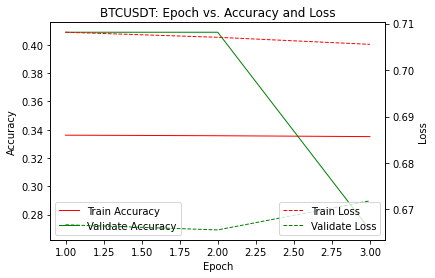

In [70]:
from pandas.plotting import table 
source_df = pd.DataFrame(m.run_data)
display(source_df)
record = {
    'sp500': [],
    'BTCUSDT': []
}
data_set = 'BTCUSDT'
    
df = source_df.loc[source_df.data_set == data_set]

for run_i in df['run'].unique():
    run_data = df.loc[df.run == run_i]
    epochs = run_data.epoch.values

    # Accuracy 1st y-axis
    fig, ax1 = plt.subplots()

    # Loss 2nd y-axis
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    colors = ['red', 'green', 'blue']

    for phase_i, phase in enumerate(['train', 'validate']):

        accuracy = run_data[f'{phase} accuracy'].values

        # record record
        if phase == 'validate':
            record[data_set].append({
                'max_accuracy': np.max(accuracy).round(3),
                'epoch': np.where(accuracy == np.max(accuracy))[0] + 1,

#                 'run': run_i
            })
#             for variable in variables:
#                 record[data_set][-1][variable] = run_data[variable].values[0]

        loss = run_data[f'{phase} loss'].values
        phase_accuracy, = ax1.plot(epochs, accuracy, 
             color=colors[phase_i],   
             linewidth=1.0
        )
        phase_accuracy.set_label(f"{phase.capitalize()} Accuracy")

        phase_loss, = ax2.plot(epochs, loss, 
             color=colors[phase_i],   
             linewidth=1.0,
             linestyle='--' 
        )
        phase_loss.set_label(f"{phase.capitalize()} Loss")

    ax1.legend(loc='lower left')
    ax2.legend(loc='lower right')

    x_label = "Epoch"
#     for variable in variables:
#         x_label += f"\n{variable} = {run_data[variable].values[0]}"
    ax1.set_xlabel(x_label)
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Loss")

    plt.title(f"{run_data['data_set'].values[0]}: Epoch vs. Accuracy and Loss")

#     ax1.set_ybound(lower=0.45, upper=.55)

    save_string = "sigma_relationship.png"
#     for variable in variables:
#         save_string = f"{data_set}_{variable}_{run_data[variable].values[0]}_" + save_string
#     plt.savefig(f"./{variables[0]}/" + save_string, bbox_inches='tight')
    plt.show()
#     break

BTCUSDT
[array([[   0, 2178,    0],
       [   0, 1749,    0],
       [   0, 2569,    0]])]
[[   0 2178    0]
 [   0 1749    0]
 [   0 2569    0]]
Normalized Confusion Matrix (Run #1)


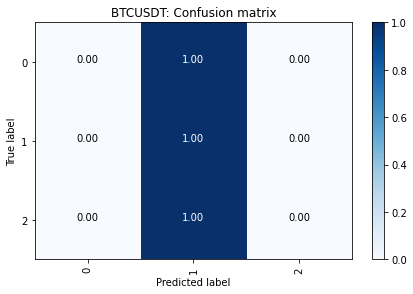

In [71]:
from copy import deepcopy
source_df = pd.DataFrame(m.run_data)
print(data_set)
def plot_confusion_matrix(df_row, normalize=True, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(df_row.confusion_matrix.values)
    cm = deepcopy(df_row.confusion_matrix.values[0])
    classes = m.global_labels #df_row['label_subset'].values[0]
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(f"Normalized Confusion Matrix (Run #{df_row.run.values[0]})")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
#     new = [[] for class_ in range(len(classes))]
#     print(new[0])
#     for row_i, row in enumerate(cm):
#         for col_i, col in enumerate(row):
#             print(row, col)
#             print(row_i, col_i)
#             print(col.item(), row.sum().item(), round(col.item() / row.sum().item(), 2))
#             new[row_i].append(round(col.item() / row.sum().item(), 2))
#             print(new)
#             print()
#         print()
    
#     cm = np.asarray(new)
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(f'{data_set}: Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    x_label = "Predicted label"
#     for variable in variables:
#         x_label += f"\n{variable} = {df_row[variable].values[0]}"
    plt.xlabel(x_label)
    
    save_string = "confusion_matrix.png"
#     for variable in variables:
#         save_string = f"{data_set}_{variable}_{df_row[variable].values[0]}_" + save_string
#     plt.savefig(f"./{variables[0]}/" + save_string, bbox_inches='tight')
        
    plt.show()
    
    
for data_set in list(source_df.data_set.unique()):
    df = source_df.loc[source_df.data_set == data_set]
#     display(df)
    for run_i in df['run'].unique():
        final_epoch_df = df.loc[df.run == run_i][-1:]
#         print(final_epoch_df.confusion_matrix)
#         plot_confusion_matrix(final_epoch_df)#, variables)
#         break
#     break
plot_confusion_matrix(df.tail(1))

In [ ]:
initial = 100
